In [1]:
from __future__ import print_function
import keras
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
batch_size = 100
num_classes = 10
epochs = 150

In [3]:
#### LOAD AND TRANSFORM
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
## DEFINE A DATA AUGMENTATION GENERATOR

datagen = ImageDataGenerator(
  featurewise_center=True,
  featurewise_std_normalization=True,
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)

In [5]:
###########################################################
# Now this is necessary due to the feature normalization: #
datagen.fit(x_train)

testdatagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

testdatagen.fit(x_train)
###########################################################

In [6]:
## DEF A BLOCK CONV + BN + GN + CONV + BN + GN + MAXPOOL 
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))

    
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))

  model.add(Conv2D(filters, (3, 3), padding='same'))
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  return model

In [7]:
## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,64)
model=CBGN(model,128)
model=CBGN(model,256)
model=CBGN(model,512)

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 32, 32, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 32, 32, 32)        0         
__________

In [8]:
## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1,
                              patience=10, min_lr=0.005)

In [9]:
## TRAINING with DA and LRA
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=testdatagen.flow(x_test, y_test),
                            callbacks=[reduce_lr],
                            verbose=1)

Epoch 1/150
500/500 [==============================] - 16s 33ms/step - loss: 1.9946 - acc: 0.2724 - val_loss: 1.7853 - val_acc: 0.3717
Epoch 2/150
500/500 [==============================] - 15s 29ms/step - loss: 1.4616 - acc: 0.4649 - val_loss: 1.3554 - val_acc: 0.5253
Epoch 3/150
500/500 [==============================] - 15s 29ms/step - loss: 1.2405 - acc: 0.5536 - val_loss: 1.3149 - val_acc: 0.5770
Epoch 4/150
500/500 [==============================] - 15s 29ms/step - loss: 1.0940 - acc: 0.6103 - val_loss: 1.4469 - val_acc: 0.5446
Epoch 5/150
500/500 [==============================] - 15s 29ms/step - loss: 0.9825 - acc: 0.6529 - val_loss: 1.1276 - val_acc: 0.6472
Epoch 6/150
500/500 [==============================] - 15s 29ms/step - loss: 0.8982 - acc: 0.6818 - val_loss: 0.9196 - val_acc: 0.6882
Epoch 7/150
500/500 [==============================] - 15s 29ms/step - loss: 0.8385 - acc: 0.7047 - val_loss: 0.9977 - val_acc: 0.6665
Epoch 8/150
500/500 [==============================] - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 15s 29ms/step - loss: 0.2432 - acc: 0.9134 - val_loss: 0.3443 - val_acc: 0.8928
Epoch 73/150
500/500 [==============================] - 15s 29ms/step - loss: 0.2440 - acc: 0.9131 - val_loss: 0.3566 - val_acc: 0.8923
Epoch 74/150
500/500 [==============================] - 15s 29ms/step - loss: 0.2389 - acc: 0.9146 - val_loss: 0.3778 - val_acc: 0.8855
Epoch 75/150
500/500 [==============================] - 15s 29ms/step - loss: 0.2243 - acc: 0.9191 - val_loss: 0.3248 - val_acc: 0.9006
Epoch 76/150
500/500 [==============================] - 15s 29ms/step - loss: 0.2180 - acc: 0.9221 - val_loss: 0.3303 - val_acc: 0.8980
Epoch 77/150
500/500 [==============================] - 15s 29ms/step - loss: 0.2139 - acc: 0.9237 - val_loss: 0.3381 - val_acc: 0.8972
Epoch 79/150
500/500 [==============================] - 15s 29ms/step - loss: 0.2118 - acc: 0.9248 - val_loss: 0.3362 - val_acc: 0.8988
Epoch 80/150
500/500 [==============================] - 15s 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 15s 29ms/step - loss: 0.1714 - acc: 0.9375 - val_loss: 0.3288 - val_acc: 0.9040
Epoch 136/150
500/500 [==============================] - 15s 29ms/step - loss: 0.1710 - acc: 0.9390 - val_loss: 0.3282 - val_acc: 0.9042
Epoch 137/150
500/500 [==============================] - 15s 29ms/step - loss: 0.1753 - acc: 0.9371 - val_loss: 0.3300 - val_acc: 0.9037
Epoch 138/150
500/500 [==============================] - 15s 29ms/step - loss: 0.1732 - acc: 0.9384 - val_loss: 0.3282 - val_acc: 0.9035
Epoch 139/150
500/500 [==============================] - 15s 29ms/step - loss: 0.1693 - acc: 0.9397 - val_loss: 0.3311 - val_acc: 0.9053
Epoch 140/150
500/500 [==============================] - 15s 29ms/step - loss: 0.1732 - acc: 0.9380 - val_loss: 0.3228 - val_acc: 0.9055
Epoch 141/150
500/500 [==============================] - 15s 29ms/step - loss: 0.1738 - acc: 0.9374 - val_loss: 0.3283 - val_acc: 0.9045
Epoch 142/150
500/500 [==============================] 

In [10]:
score = model.evaluate_generator(testdatagen.flow(x_test, y_test,batch_size=batch_size), verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

100/100 [==============================] - 1s 5ms/step
Test loss: 0.32875621743500233
Test accuracy: 0.904400001168251


In [11]:
from keras.models import load_model

model.save('cnn9044.h5')

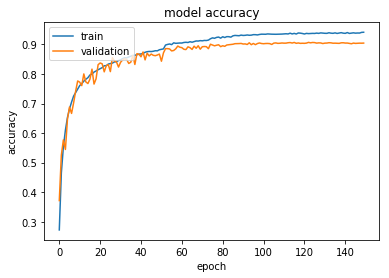

In [12]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('gila.png')
plt.show()